<a href="https://colab.research.google.com/github/haytham918/low-rank-expectile/blob/main/LRE_wt_BFGS_ActualData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from scipy.stats import norm
from scipy.optimize import minimize

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Matrix shape is : (288, 334)
Number of Missing values:  28674
Proportion of Missing values:  29.809131736526943 %
Index of the interval where there is no data at all:  (array([], dtype=int64),)


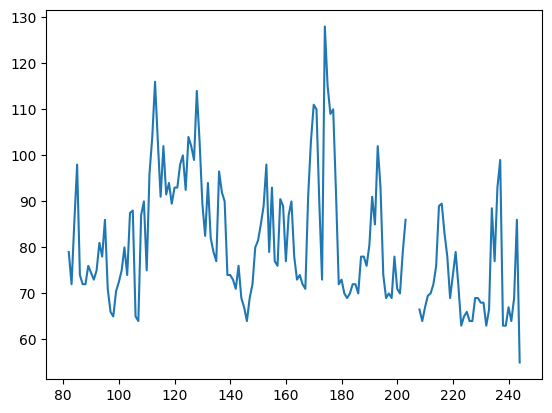

In [21]:
from google.colab import drive
drive.mount('/content/drive')
processed_df = pd.read_csv("/content/drive/MyDrive/low-rank-expectile/processed_heartrate.csv")
# Convert the df to numpy matrix
user_times_matrix = processed_df.values
# Nan Mask Matrix for the matrix
nan_mask = np.isnan(user_times_matrix)

number_missing = np.sum(nan_mask)
matrix_shape = user_times_matrix.shape
print("Matrix shape is :", matrix_shape)
print("Number of Missing values: ", number_missing)
print("Proportion of Missing values: ", number_missing / (matrix_shape[0] * matrix_shape[1]) * 100, "%")

# Check if there is any interval that there is no data from any user
print("Index of the interval where there is no data at all: ", np.where(nan_mask.sum(axis=1) == matrix_shape[1]))
# Get the masked matrix so that we ignore nan values
masked_matrix = np.ma.array(user_times_matrix, mask=nan_mask)
# print(np.mean(masked_matrix, axis=1)[287])
interval_array = np.arange(0, 288)
plt.plot(interval_array, user_times_matrix[:,22])

In [22]:
def get_observed_mask(X):
    return ~np.isnan(X)

def compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau):
    m, n = X.shape
    k = U.shape[1]

    # Construct approximation and error matrices
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    # Get weight
    W = np.where(error_matrix >= 0, tau, 1 - tau)

    # Calculate gradient
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    return R_grad, C_grad, U_grad, V_grad

def expectile_loss_vectorized(X, R, C, U, V, M, tau):
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()

    return loss

def expectile_gradient_descent_vectorized(X, k, epochs, eta, tau):
    m, n = X.shape
    R = np.zeros(m)
    C = np.zeros(n)
    U = np.random.normal(0, 0.1, (m, k))
    V = np.random.normal(0, 0.1, (n, k))
    M = get_observed_mask(X)

    for epoch in range(epochs):
        R_grad, C_grad, U_grad, V_grad = compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau)
        R -= eta * R_grad
        C -= eta * C_grad
        U -= eta * U_grad
        V -= eta * V_grad

        if epoch % 10 == 9:
            current_loss = expectile_loss_vectorized(X, R, C, U, V, M, tau)
            print(f"Epoch {epoch+1}: Loss = {current_loss}")

    return R, C, U, V

In [23]:
def flatten_parameters(R, C, U, V):
    return np.concatenate([R, C, U.flatten(), V.flatten()])

def unflatten_parameters(params, m, n, k):
    R = params[:m]
    C = params[m:m+n]
    U = params[m+n:m+n+m*k].reshape(m, k)
    V = params[m+n+m*k:].reshape(n, k)
    return R, C, U, V

def total_loss_and_gradient(params, X, M, tau, m, n, k, loss_array):
    R, C, U, V = unflatten_parameters(params, m, n, k)
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()
    loss_array.append(loss)

    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    grad = flatten_parameters(R_grad, C_grad, U_grad, V_grad)
    return loss, grad


def optimize_with_bfgs(X, k, tau, loss_array):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(0, 1, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method='BFGS', jac=True, options={'disp': True, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    print(f"Array Length: {len(loss_array)}")
    return R, C, U, V

def optimize_with_lbfgs(X, k, tau, loss_array):
    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(0, 1, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method='L-BFGS-B', jac=True, options={'disp': True, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    print(f"Array Length: {len(loss_array)}")
    return R, C, U, V

def optimize_with_bfgs_sep_init(X, k, tau, row_mean, col_mean, loss_array):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_r_param = row_mean
    initial_c_param = col_mean
    initial_uv_param = np.random.normal(0, 1, m*k + n*k)
    initial_params = np.concatenate((initial_r_param, initial_c_param, initial_uv_param))

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method='BFGS', jac=True, options={'disp': True, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    print(f"Array Length: {len(loss_array)}")
    return R, C, U, V

def optimize_with_lbfgs_sep_init(X, k, tau, row_mean, col_mean, loss_array):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_r_param = row_mean
    initial_c_param = col_mean
    initial_uv_param = np.random.normal(0, 1, m*k + n*k)
    initial_params = np.concatenate((initial_r_param, initial_c_param, initial_uv_param))

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method='L-BFGS-B', jac=True, options={'disp': True, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    print(f"Array Length: {len(loss_array)}")
    return R, C, U, V

def standardize(R, C, U, V):
  for j in range(V.shape[1]):
    m = V[:,j].mean()
    R += U[:,j] * m
    V[:, j] -= m
  return R, C, U, V

In [24]:
mean_nona = np.mean(masked_matrix)
std_val = np.std(masked_matrix)
X_normalized = user_times_matrix - mean_nona
X_normalized /= std_val
print("MEAN", mean_nona)
print("STD: ", std_val)
# print("Row Mean: ", row_mean)
# print("Col Mean: ", col_mean)
print(X_normalized)
X_new = np.ma.array(X_normalized, mask=np.isnan(X_normalized))
row_mean = np.mean(X_new, 1)
col_mean = np.mean(X_new, 0)
print("NEW MEAN: ", np.mean(X_new))
print("NEW STD: ", np.std(X_new))


MEAN 73.7046491306022
STD:  16.320639272086176
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
NEW MEAN:  2.1173790461052187e-16
NEW STD:  1.0


In [25]:
# LBBFGS, STANDAD NORMAL
# lbfgs_normal_loss_array = []
# tau = 0.1
# R_l_01, C_l, U_l_01, V_l_01 = optimize_with_lbfgs(X_normalized, 1, tau, lbfgs_normal_loss_array)
# X_hat_l = R_l[:,np.newaxis]*std_val + C_l*std_val + U_l*std_val @ V_l.T + mean_nona
# print(X_hat_l)
# plt.plot(interval_array, user_times_matrix[:,22])
# plt.plot(interval_array, X_hat_l[:,22])
# plt.plot(U_l * std_val)

In [26]:
# LBBFGS, STANDAD NORMAL
# lbfgs_normal_loss_array = []
# tau = 0.9
# R_l_09, C_l, U_l_09, V_l_09 = optimize_with_lbfgs(X_normalized, 1, tau, lbfgs_normal_loss_array)
# X_hat_l = R_l[:,np.newaxis]*std_val + C_l*std_val + U_l*std_val @ V_l.T + mean_nona
# print(X_hat_l)
# plt.plot(interval_array, user_times_matrix[:,22])
# plt.plot(interval_array, X_hat_l[:,22])
# plt.plot(U_l * std_val)

In [27]:
# LBBFGS, STANDAD NORMAL
# lbfgs_normal_loss_array = []
# tau = 0.5
# R_l_05, C_l, U_l_05, V_l_05 = optimize_with_lbfgs(X_normalized, 1, tau, lbfgs_normal_loss_array)
# X_hat_l = R_l[:,np.newaxis]*std_val + C_l*std_val + U_l*std_val @ V_l.T + mean_nona
# print(X_hat_l)
# plt.plot(interval_array, user_times_matrix[:,22])
# plt.plot(interval_array, X_hat_l[:,22])


In [28]:
# u = [U_l_01, U_l_05, U_l_09]
# v = [V_l_01, V_l_05, V_l_09]
# for i in range(3):
#   w = np.linalg.norm(u[i])
#   u[i] = u[i] / w
#   v[i] = v[i] * w
#   ii = np.argmax(np.abs(u[i]))
#   if u[i][ii] < 0:
#     u[i] = u[i] * -1
#     v[i] = v[i] * -1
#   plt.plot(u[i] * std_val, label=f"{i}")
# plt.plot(U_l_01 * std_val, label="0.1")
# plt.plot(U_l_09 * std_val, label="0.9")
# plt.plot(U_l_05 * std_val,label="0.5")


def maintain_uv_plot_direction(u_list, v_list):
  for i in range(len(u_list)):
    w = np.linalg.norm(u_list[i])
    u_list[i] = u_list[i] / w
    v_list[i] = v_list[i] * w
    index_of_max_abs_val = np.argmax(np.abs(u_list[i]))
    if u_list[i][index_of_max_abs_val] < 0:
      u_list[i] = u_list[i] * -1
      v_list[i] = v_list[i] * -1


Final Loss: 0.09259434059690787
Array Length: 51
Final Loss: 0.15671897546679509
Array Length: 126
Final Loss: 0.20508938092926682
Array Length: 103
Final Loss: 0.24146481189008756
Array Length: 151
Final Loss: 0.26571666121602694
Array Length: 79
Final Loss: 0.27681933458588065
Array Length: 76
Final Loss: 0.27193518386901744
Array Length: 91
Final Loss: 0.24540820489941842
Array Length: 86
Final Loss: 0.18269008745719206
Array Length: 62
Final Loss: 0.09258385569741805
Array Length: 52
Final Loss: 0.15636567660866585
Array Length: 61
Final Loss: 0.20508818917135913
Array Length: 89
Final Loss: 0.2452758118318381
Array Length: 82
Final Loss: 0.265708995541618
Array Length: 69
Final Loss: 0.2767689888411618
Array Length: 90
Final Loss: 0.2719759103769636
Array Length: 77
Final Loss: 0.24545073193605527
Array Length: 104
Final Loss: 0.1824700654691459
Array Length: 97
Final Loss: 0.09212583642941935
Array Length: 58
Final Loss: 0.1567083271770882
Array Length: 72
Final Loss: 0.205132729

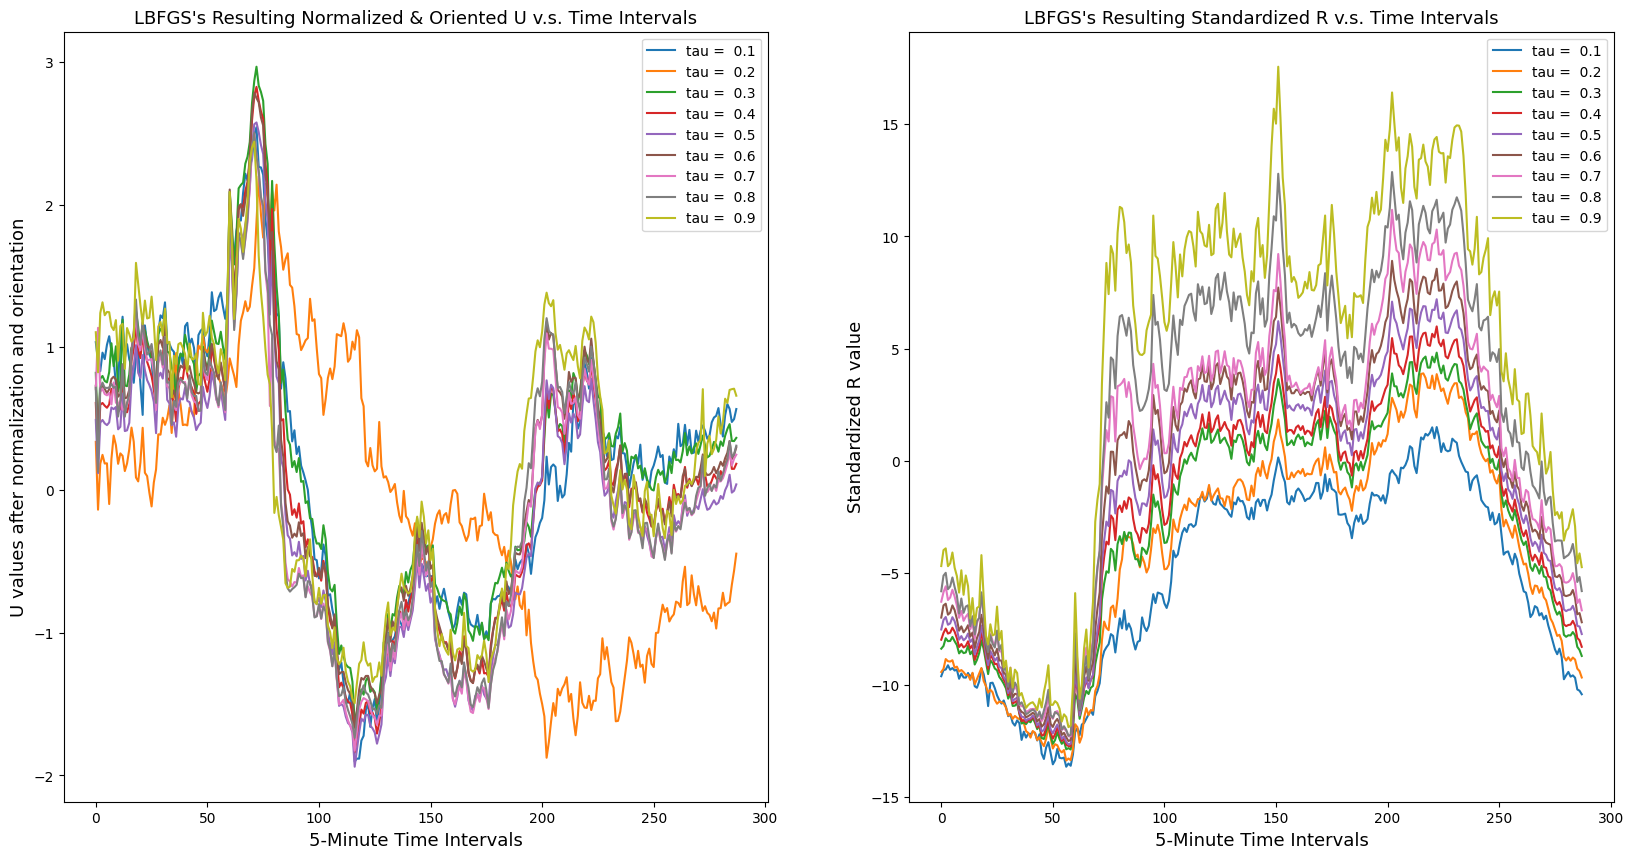

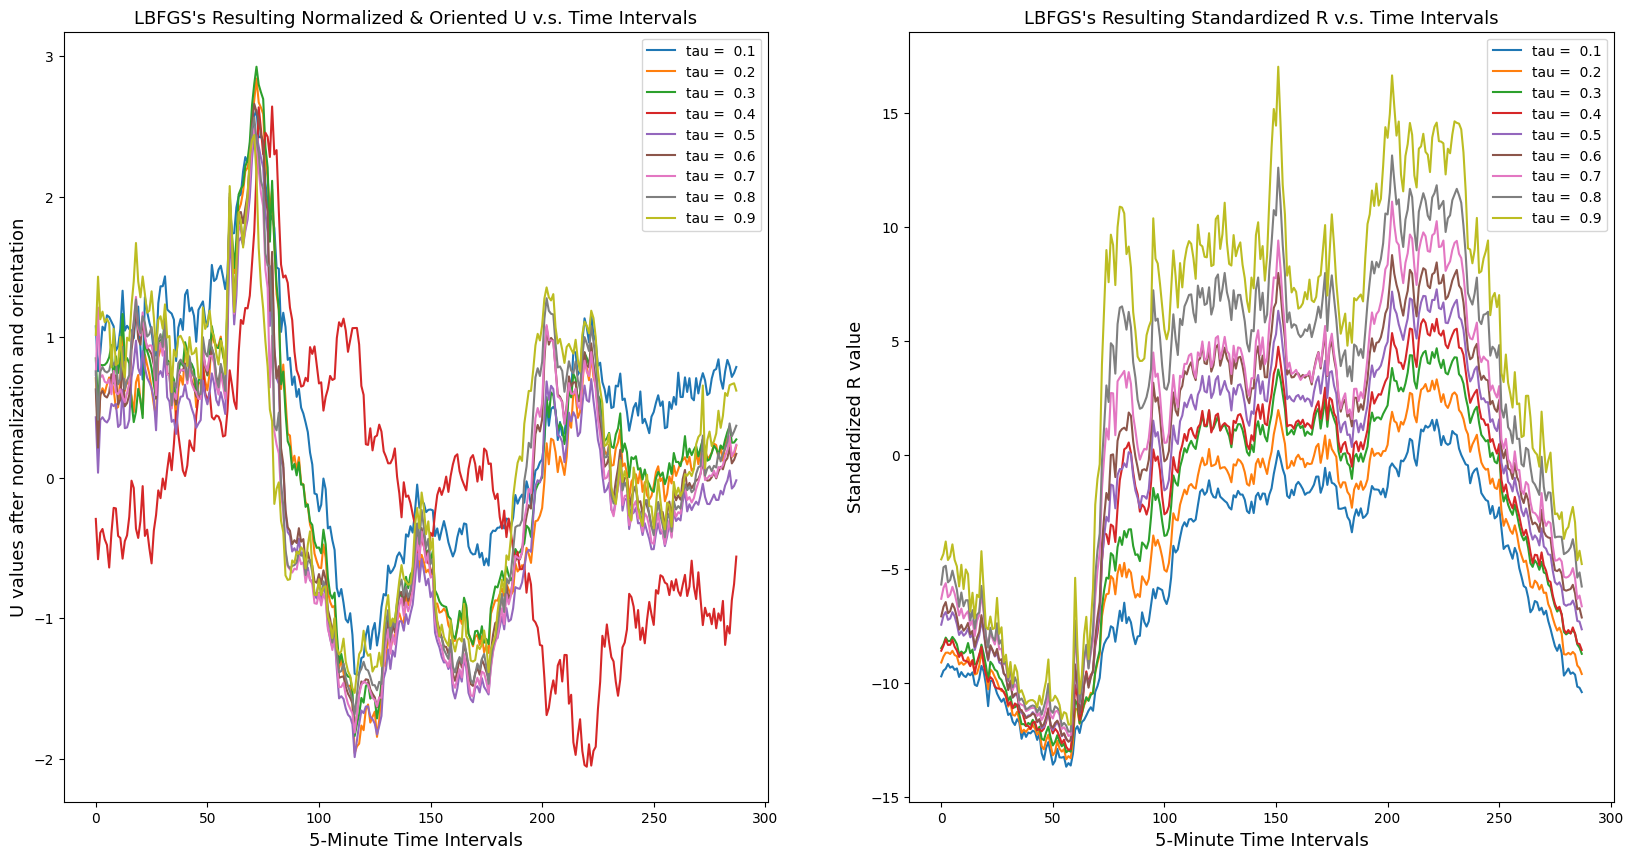

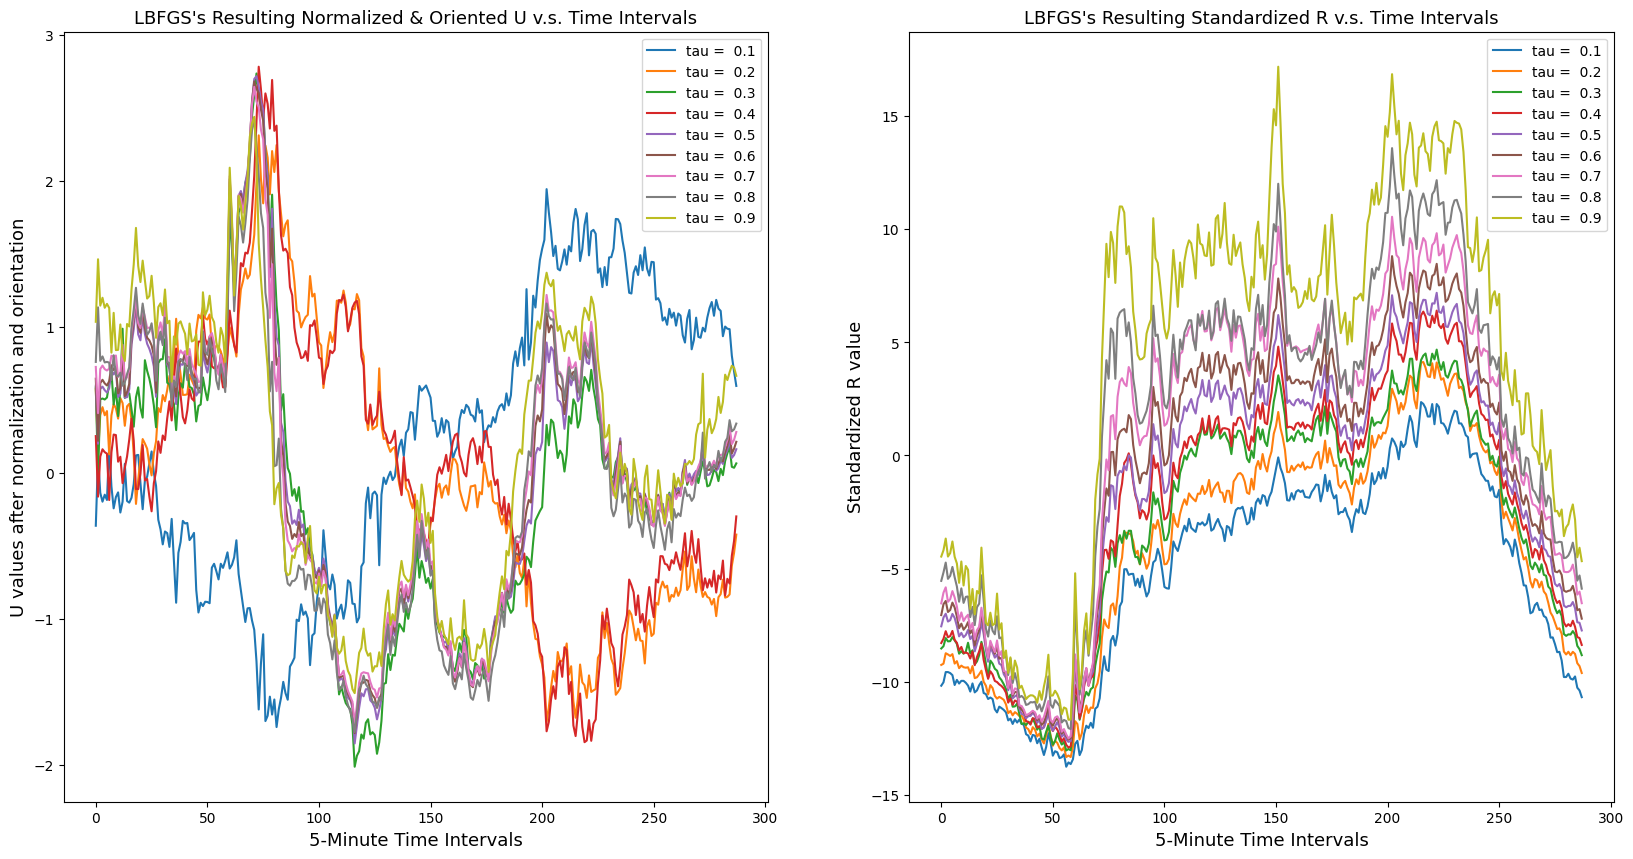

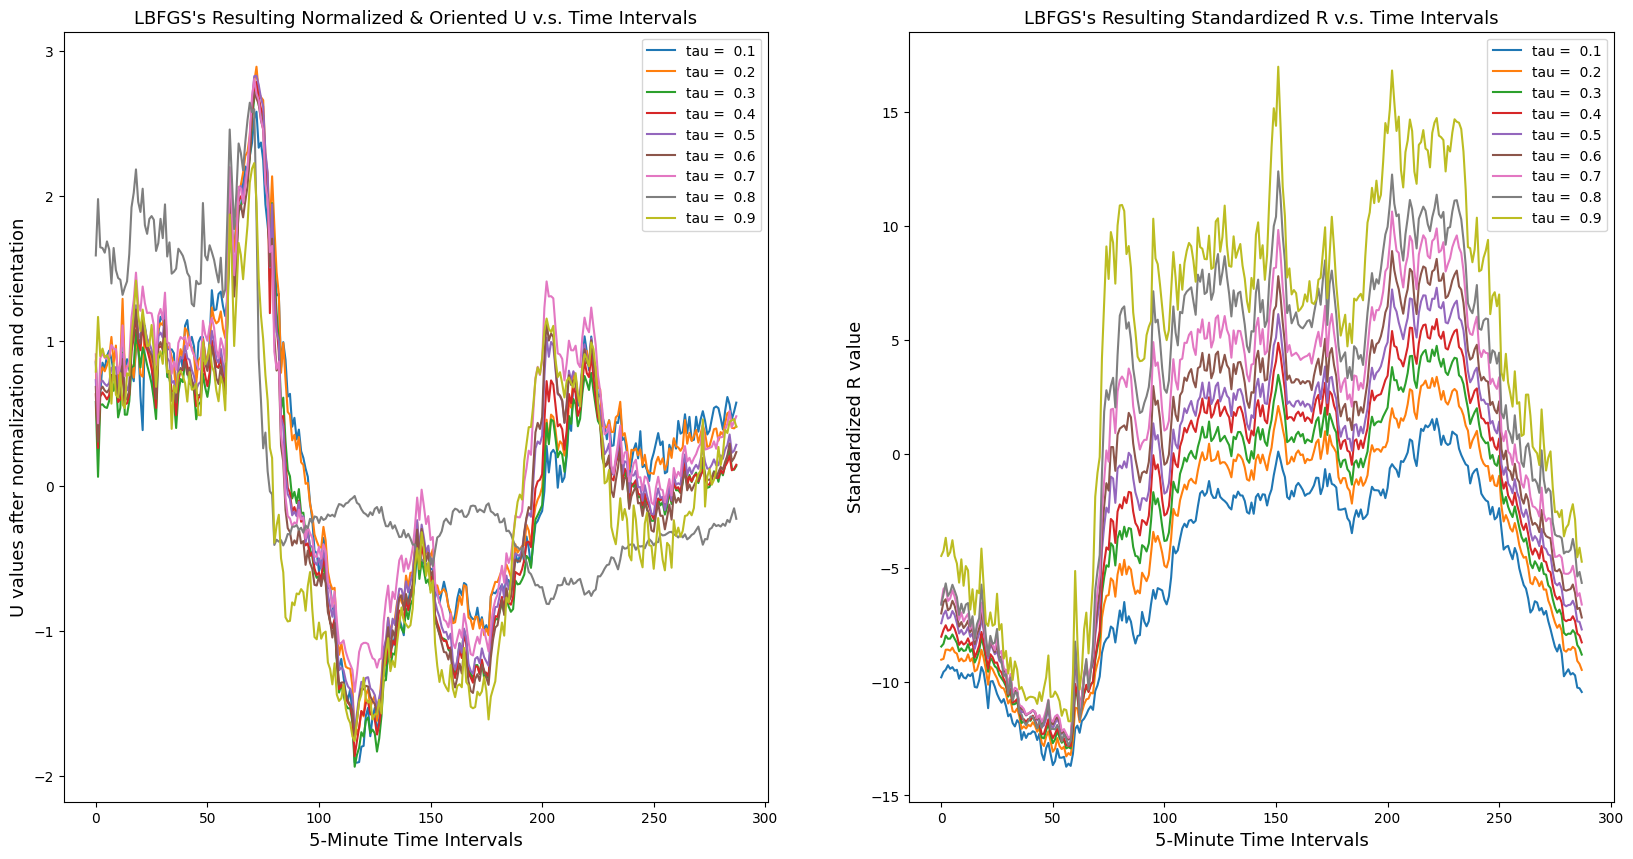

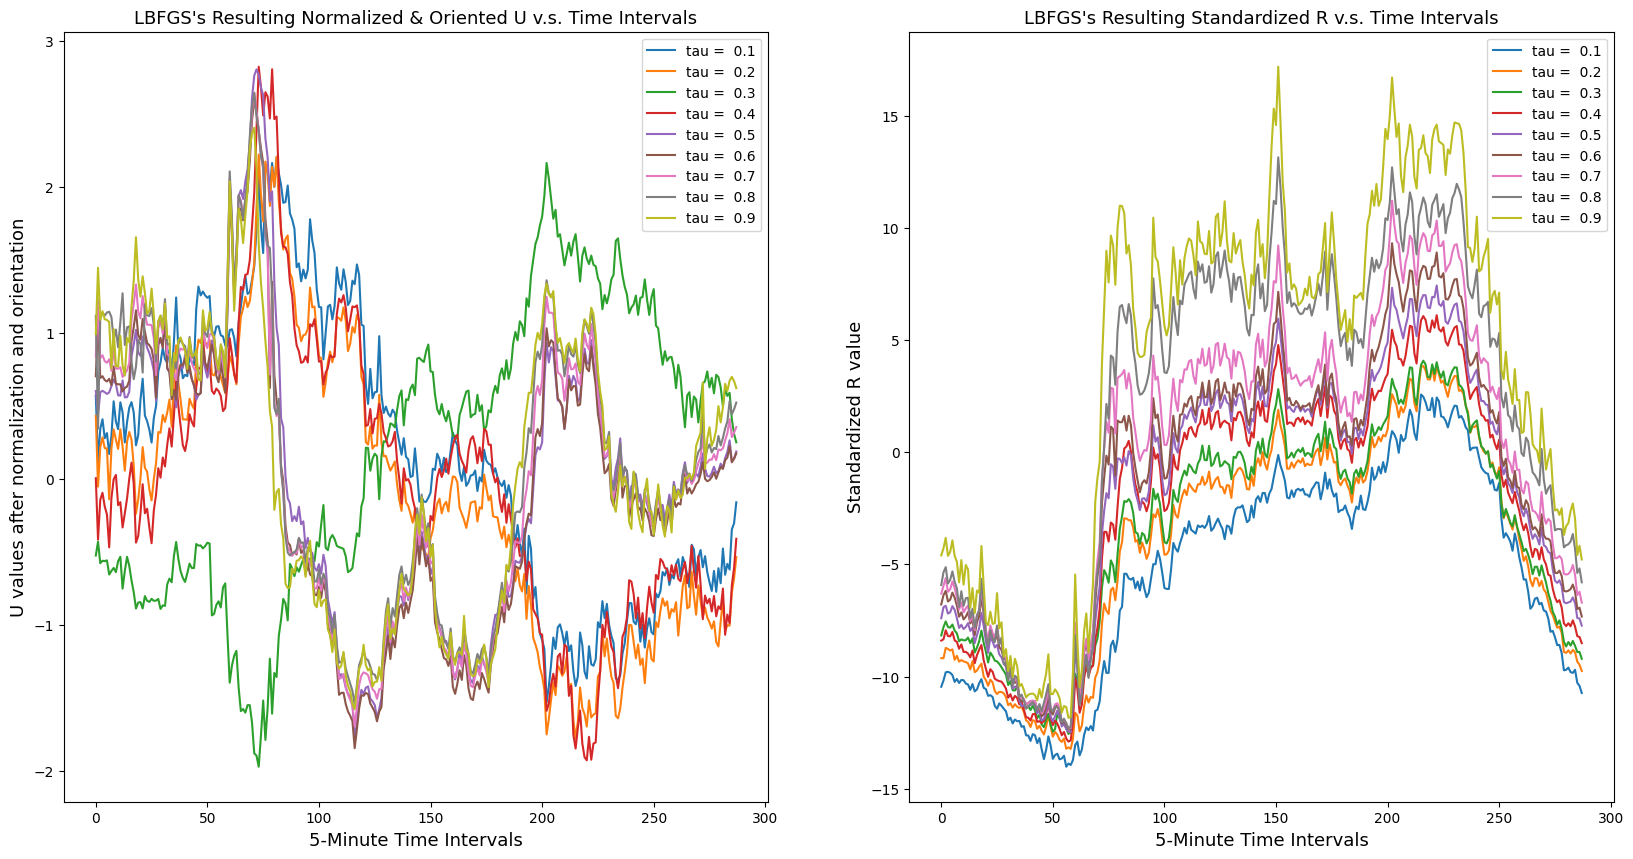

In [48]:
# Code to display U and R
def lbfgs_sep_plotter():
  u_list = []
  v_list = []
  r_list = []
  c_list = []
  loss_array = []
  for tau_val in np.arange(0.1, 1, 0.1):
    lbfgs_loss_array = []
    R_l, C_l, U_l, V_l = optimize_with_lbfgs_sep_init(X_normalized, 1, tau_val, row_mean, col_mean, lbfgs_loss_array)
    R, C, U, V = standardize(R_l, C_l, U_l, V_l)
    r_list.append(R)
    c_list.append(C)
    u_list.append(U)
    v_list.append(V)
  maintain_uv_plot_direction(u_list, v_list)

  fig, axs = plt.subplots(1, 2, figsize=(20,10))
  axs[0].set_ylabel("U values after normalization and orientation", fontsize=13)
  axs[0].set_xlabel("5-Minute Time Intervals", fontsize=13)
  axs[0].set_title("LBFGS's Resulting Normalized & Oriented U v.s. Time Intervals", fontsize=13)
  for m in range(len(u_list)):
    tau_value = (m+1) * 0.1
    axs[0].plot(u_list[m] * std_val, label=f"tau = {tau_value: .1f}")
  axs[0].legend(fontsize=10)


  axs[1].set_ylabel("Standardized R value", fontsize=13)
  axs[1].set_xlabel("5-Minute Time Intervals", fontsize=13)
  axs[1].set_title("LBFGS's Resulting Standardized R v.s. Time Intervals", fontsize=13)
  for m in range(len(r_list)):
    tau_value = (m+1) * 0.1
    axs[1].plot(r_list[m] * std_val, label=f"tau = {tau_value: .1f}")
  axs[1].legend(fontsize=10)

lbfgs_sep_plotter();
lbfgs_sep_plotter();
lbfgs_sep_plotter();
lbfgs_sep_plotter();
lbfgs_sep_plotter();


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.092150
         Iterations: 500
         Function evaluations: 505
         Gradient evaluations: 505
Final Loss: 0.09214955324231987
Array Length: 505
         Current function value: 0.156750
         Iterations: 500
         Function evaluations: 504
         Gradient evaluations: 504
Final Loss: 0.15675016202862144
Array Length: 504
         Current function value: 0.205292
         Iterations: 500
         Function evaluations: 503
         Gradient evaluations: 503
Final Loss: 0.20529232841489212
Array Length: 503
         Current function value: 0.241654
         Iterations: 500
         Function evaluations: 505
         Gradient evaluations: 505
Final Loss: 0.24165429038185526
Array Length: 505
         Current function value: 0.271219
         Iterations: 500
         Function evaluations: 504
         Gradient evaluations: 504
Final Loss: 0.27121903670534436
Array Length: 504
         Current function value: 0.276961
         Iterations: 50

KeyboardInterrupt: 

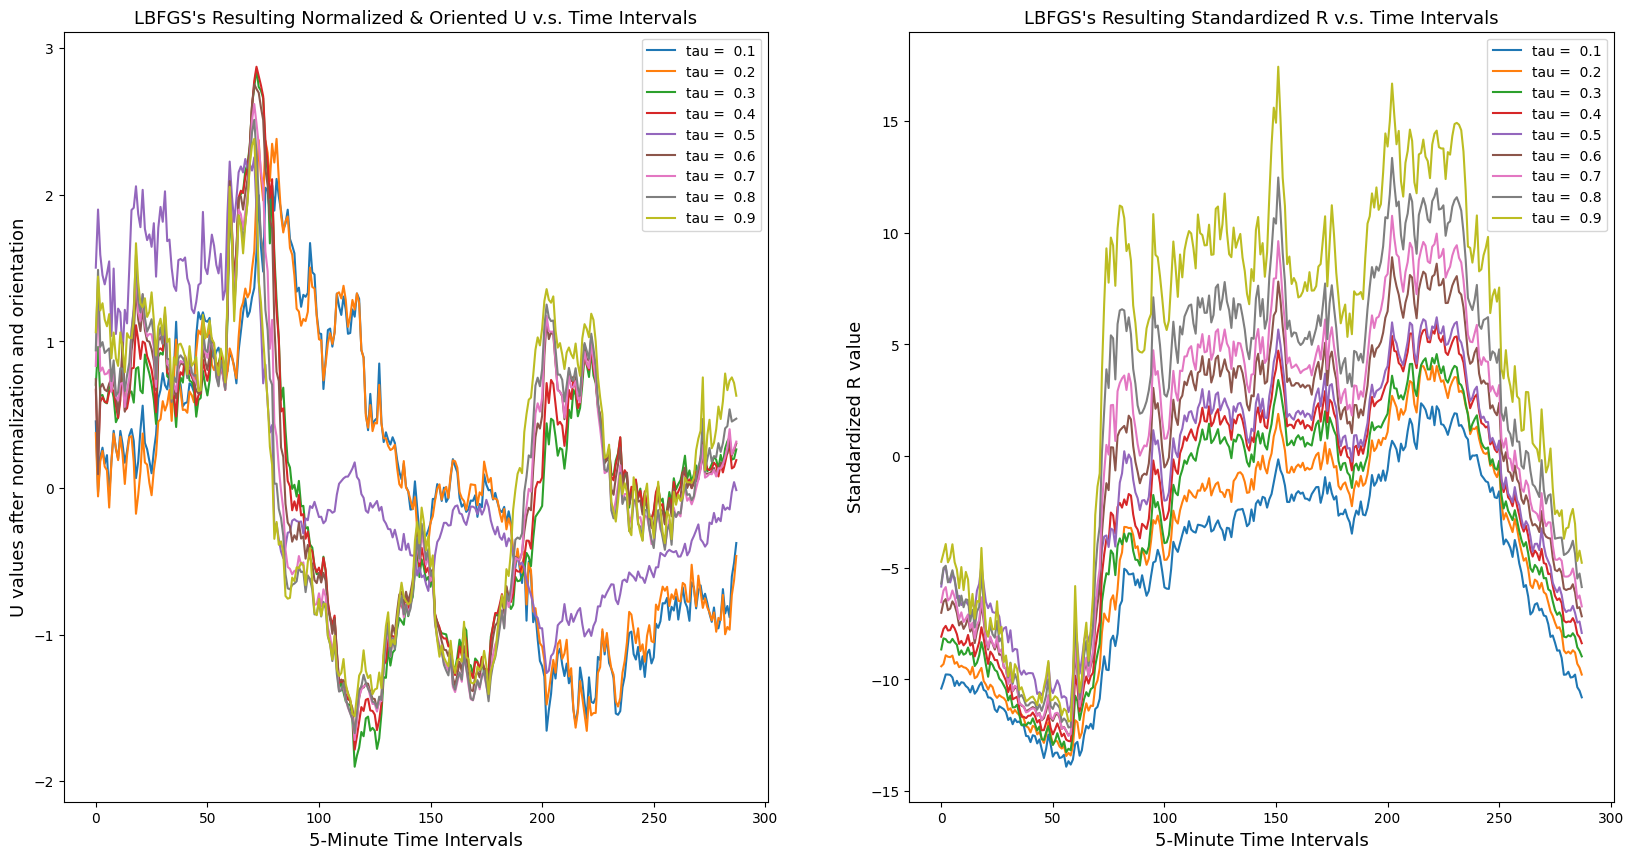

In [49]:
# Code to display U and R
def bfgs_sep_plotter():
  u_list = []
  v_list = []
  r_list = []
  c_list = []
  loss_array = []
  for tau_val in np.arange(0.1, 1, 0.1):
    bfgs_loss_array = []
    R_l, C_l, U_l, V_l = optimize_with_bfgs_sep_init(X_normalized, 1, tau_val, row_mean, col_mean, bfgs_loss_array)
    R, C, U, V = standardize(R_l, C_l, U_l, V_l)
    r_list.append(R)
    c_list.append(C)
    u_list.append(U)
    v_list.append(V)
  maintain_uv_plot_direction(u_list, v_list)

  fig, axs = plt.subplots(1, 2, figsize=(20,10))
  axs[0].set_ylabel("U values after normalization and orientation", fontsize=13)
  axs[0].set_xlabel("5-Minute Time Intervals", fontsize=13)
  axs[0].set_title("LBFGS's Resulting Normalized & Oriented U v.s. Time Intervals", fontsize=13)
  for m in range(len(u_list)):
    tau_value = (m+1) * 0.1
    axs[0].plot(u_list[m] * std_val, label=f"tau = {tau_value: .1f}")
  axs[0].legend(fontsize=10)


  axs[1].set_ylabel("Standardized R value", fontsize=13)
  axs[1].set_xlabel("5-Minute Time Intervals", fontsize=13)
  axs[1].set_title("LBFGS's Resulting Standardized R v.s. Time Intervals", fontsize=13)
  for m in range(len(r_list)):
    tau_value = (m+1) * 0.1
    axs[1].plot(r_list[m] * std_val, label=f"tau = {tau_value: .1f}")
  axs[1].legend(fontsize=10)

bfgs_sep_plotter();
bfgs_sep_plotter();
bfgs_sep_plotter();
bfgs_sep_plotter();
bfgs_sep_plotter();

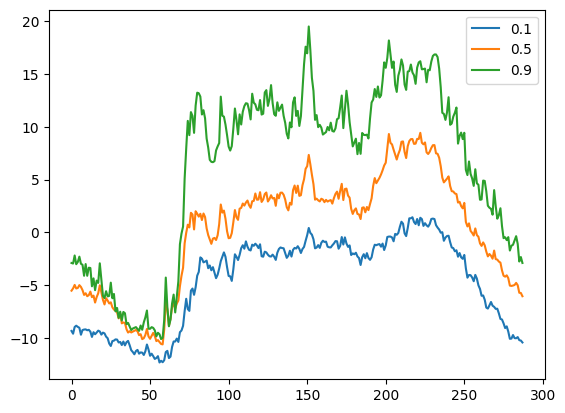

In [ ]:
# plt.plot(R_l_01 * std_val, label="0.1")
# plt.plot(R_l_05 * std_val, label="0.5")
# plt.plot(R_l_09 * std_val, label="0.9")
# plt.legend()

Final Loss: 0.21526875003696483
Array Length: 94
[[ 52.24236379  59.56386121  63.85198466 ...  65.10129075 122.60477544
  112.8432996 ]
 [ 48.22984808  54.32023835  63.88985164 ...  66.19410782 134.69961998
  122.53010511]
 [ 52.08564817  58.0146317   64.21670847 ...  66.0067829  124.88067334
  114.60426748]
 ...
 [ 56.92827836  59.463762    63.69650672 ...  65.73830921 109.85801084
  101.9357117 ]
 [ 56.57714859  59.052152    63.89949989 ...  66.05020455 111.67908836
  103.44527667]
 [ 57.49369121  62.32784218  63.98908124 ...  65.23270653 108.6938522
  101.30170906]]


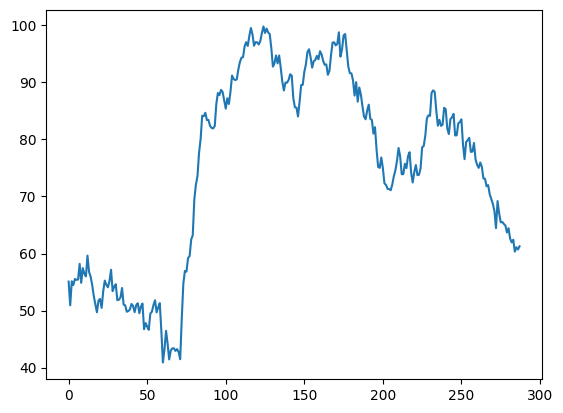

In [ ]:
# LBBFGS, Use ROW/COL Mean
lbfgs_mean_loss_array = []
tau = 0.8
R_l_s, C_l_s, U_l_s, V_l_s = optimize_with_lbfgs_sep_init(X_normalized, 2, tau, row_mean, col_mean, lbfgs_mean_loss_array)
X_hat_l_s = R_l_s[:,np.newaxis]*std_val + C_l_s*std_val + U_l_s*std_val @ V_l_s.T + mean_nona
print(X_hat_l_s)
plt.plot(interval_array, X_hat_l_s[:,22])

         Current function value: 0.215438
         Iterations: 500
         Function evaluations: 506
         Gradient evaluations: 506
Final Loss: 0.21543774504645313
Array Length: 506
[[ 70.24898319 105.99722066  68.2136198  ...  62.62101505  63.8538495
   58.04961305]
 [ 71.73255822 110.53594571  69.17684112 ...  63.10704022  60.65395067
   56.32197125]
 [ 71.87258347 107.31273014  68.98124127 ...  63.41983489  62.24884357
   57.76635693]
 ...
 [ 72.97040826  96.33431382  67.31353422 ...  63.54852869  62.21368842
   59.71612165]
 [ 73.43242648  95.01290241  67.49611707 ...  63.99880833  63.03383556
   60.62066436]
 [ 69.39816793  89.58554763  66.59035026 ...  63.36449535  72.91355944
   65.14998926]]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


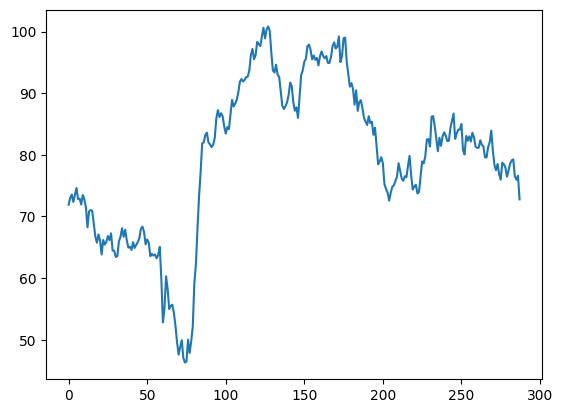

In [ ]:
# BFGS, standard normal
bfgs_normal_loss_array = []
tau = 0.8
R, C, U, V = optimize_with_bfgs(X_normalized, 2, tau, bfgs_normal_loss_array)
X_hat = R[:,np.newaxis]*std_val + C*std_val + U*std_val @ V.T + mean_nona
print(X_hat)
plt.plot(interval_array, X_hat[:,22])

         Current function value: 0.215676
         Iterations: 500
         Function evaluations: 505
         Gradient evaluations: 505
Final Loss: 0.2156755004730421
Array Length: 505
[[ 52.35173491  59.474547    63.6737555  ...  65.44273813 125.88340103
  117.48618362]
 [ 48.65275223  55.09775516  63.74590818 ...  66.4929697  138.91653517
  128.41857249]
 [ 52.45819716  58.67844454  64.0421025  ...  66.1730635  128.17629556
  119.36764351]
 ...
 [ 56.39301414  61.73903312  63.59980523 ...  65.16643492 114.67937106
  107.79346282]
 [ 56.89322549  61.20218708  63.75747733 ...  65.61289247 114.97540544
  107.93929398]
 [ 57.3150872   64.33527236  63.9849316  ...  64.87001654 111.32978217
  105.23269692]]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


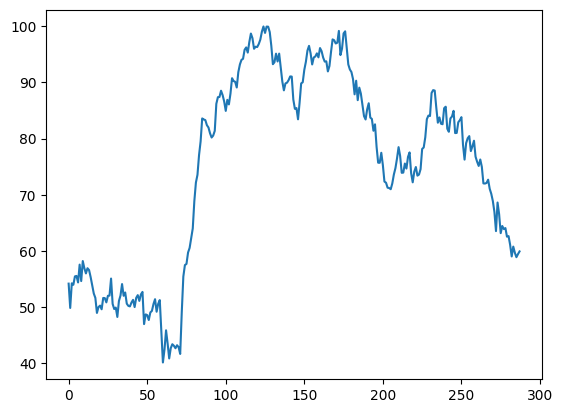

In [ ]:
# BFGS, Use Row/Col Mean
bfgs_mean_loss_array = []
tau = 0.8
R_s, C_s, U_s, V_s = optimize_with_bfgs_sep_init(X_normalized, 2, tau, row_mean, col_mean, bfgs_mean_loss_array)
X_hat_s = R_s[:,np.newaxis]*std_val + C_s*std_val + U_s*std_val @ V_s.T + mean_nona
print(X_hat_s)
plt.plot(interval_array, X_hat_s[:,22])